# 0. The problem

### Context

Our client is an Insurance company that has provided Health Insurance to its customers. Now the company needs your help to build a model capable of predict if a policyholder (customers) from past year will also be interested in **Vehicle Insurance**, also provided by the company.

A prediction model will help the company being more accurate in its communication strategy to reach out those customers most likely to purchase a vehicle insurance.

### Solution

Supposing that the company does not have enough resources to contact every client in the data base, a good strategy would be creating a list of clients ordered by their propensity of being interested in Vehicle Insurance. Such strategy would allow the company to maximize the effort of reaching the potential clients in comparison to a randomized choice in a list.

Let's say the company has a marketing budget to contact **25000** person.

The purpose is to employ a Machine Learning model to order a list of clients, from the most interested in to the less one. Next, with that list it is possible to plot a Cumulative Gains Curve to evaluate the effectiveness of the model in comparison to a randomized choice.

# 1. Data description

## 1.1. Imports

In [168]:
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, TargetEncoder
from sklearn.feature_selection import mutual_info_classif

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import scikitplot as skplt

In [169]:
# Random seed
seed = 42

In [170]:
# Functions
def some_metrics(y_pred, y_true):
    accuracy = accuracy_score(y_pred=y_pred, y_true=y_true)
    precision = precision_score(y_pred=y_pred, y_true=y_true)
    recall = recall_score(y_pred=y_pred, y_true=y_true)
    f1 = f1_score(y_pred=y_pred, y_true=y_true)
    print(f'Accuracy: {100*accuracy:.4f}%')
    print(f'Precision: {100*precision:.4f}%')
    print(f'Recall: {100*recall:.4f}%')
    print(f'F1 score: {f1:.4f}')

## 1.2. Loading data

In [171]:
PATH = '/home/ezequiel/Documentos/Comunidade_DS/car_insurance_sell/data/raw/train.csv'

df_raw = pd.read_csv(filepath_or_buffer=PATH)
df = df_raw.copy()

# 2. Exploratory Data Analysis (EDA)

## 2.1. Data description

In [172]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Columns description:

* **id**                      Unique ID for the customer  
* **Gender**                  Gender of the customer  
* **Age**                     Age of the customer  
* **Driving_License**         0 : Customer does not have DL, 1 : Customer already has DL  
* **Region_Code** 	        Unique code for the region of the customer  
* **Previously_Insured**	    1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance  
* **Vehicle_Age** 	        Age of the Vehicle  
* **Vehicle_Damage** 	        1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.  
* **Annual_Premium** 	        The amount customer needs to pay as premium in the year  
* **Policy_Sales_Channel** 	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.  
* **Vintage** 	            Number of Days which customer has been associated with the company  
* **Response** 	            1 : Customer is interested, 0 : Customer is not interested

* Currency: Idian Rupee (Rs)

In [173]:
#df_train.columns = df_train.columns.str.lower()

#### Shape

In [174]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 381109
Number of columns: 12


In [175]:
## id column has no importance and can be removed
#df_train.drop(columns=['id'], inplace=True)

#### Types

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


**Summary**
- Categorical variables:
    - gender (object)
    - driving license (int64)
    - previously insured (int64)
    - region code (float64)
    - policy sales channel (float64)
    - vehicle age (object)
    - vehicle damage (object)
    - response (int64)
- Variable representing numerical variables:
    - age
    - annual premium
    - vintage

#### Transform type of some categorical features

In [177]:
df['Driving_License'] = df['Driving_License'].astype('category')
df['Previously_Insured'] = df['Previously_Insured'].astype('category')
df['Region_Code'] = df['Region_Code'].astype('category')
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('category')

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   id                    381109 non-null  int64   
 1   Gender                381109 non-null  object  
 2   Age                   381109 non-null  int64   
 3   Driving_License       381109 non-null  category
 4   Region_Code           381109 non-null  category
 5   Previously_Insured    381109 non-null  category
 6   Vehicle_Age           381109 non-null  object  
 7   Vehicle_Damage        381109 non-null  object  
 8   Annual_Premium        381109 non-null  float64 
 9   Policy_Sales_Channel  381109 non-null  category
 10  Vintage               381109 non-null  int64   
 11  Response              381109 non-null  int64   
dtypes: category(4), float64(1), int64(4), object(3)
memory usage: 25.1+ MB


#### Missing values
-> No missing values

In [179]:
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

#### Duplicated
-> The number of duplicates is low, so they were removed with no further investigation

In [180]:
df.duplicated().sum()

0

In [181]:
#df_train.drop_duplicates(inplace=True)

#### Target variable
-> Unbalanced target

<Axes: xlabel='Response', ylabel='count'>

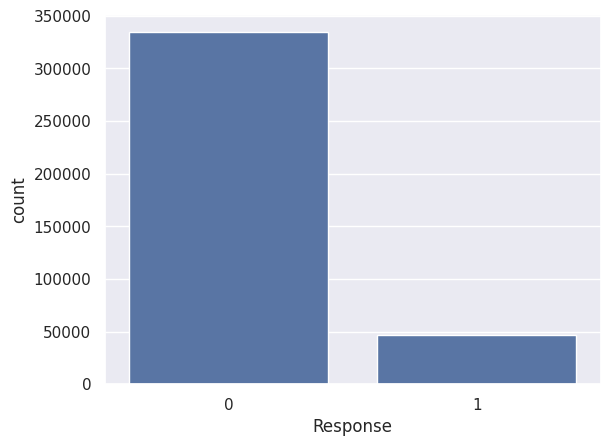

In [182]:
sns.countplot(data=df, x=df['Response'])

In [183]:
print(f'Total of interested: {df["Response"].value_counts(normalize=True)[1]*100:.2f}%')
print(f'Total of not interested: {df["Response"].value_counts(normalize=True)[0]*100:.2f}%')

Total of interested: 12.26%
Total of not interested: 87.74%


#### Numerical variables

In [184]:
num_columns = df.select_dtypes(exclude=['object', 'category']).columns.tolist()
num_columns.pop(0)
num_columns

['Age', 'Annual_Premium', 'Vintage', 'Response']

In [185]:
df[num_columns].describe()

,Age,Annual_Premium,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,30564.389581,154.347397,0.122563
std,15.511611,17213.155057,83.671304,0.327936
min,20.000000,2630.000000,10.000000,0.000000
25%,25.000000,24405.000000,82.000000,0.000000
50%,36.000000,31669.000000,154.000000,0.000000
75%,49.000000,39400.000000,227.000000,0.000000
max,85.000000,540165.000000,299.000000,1.000000


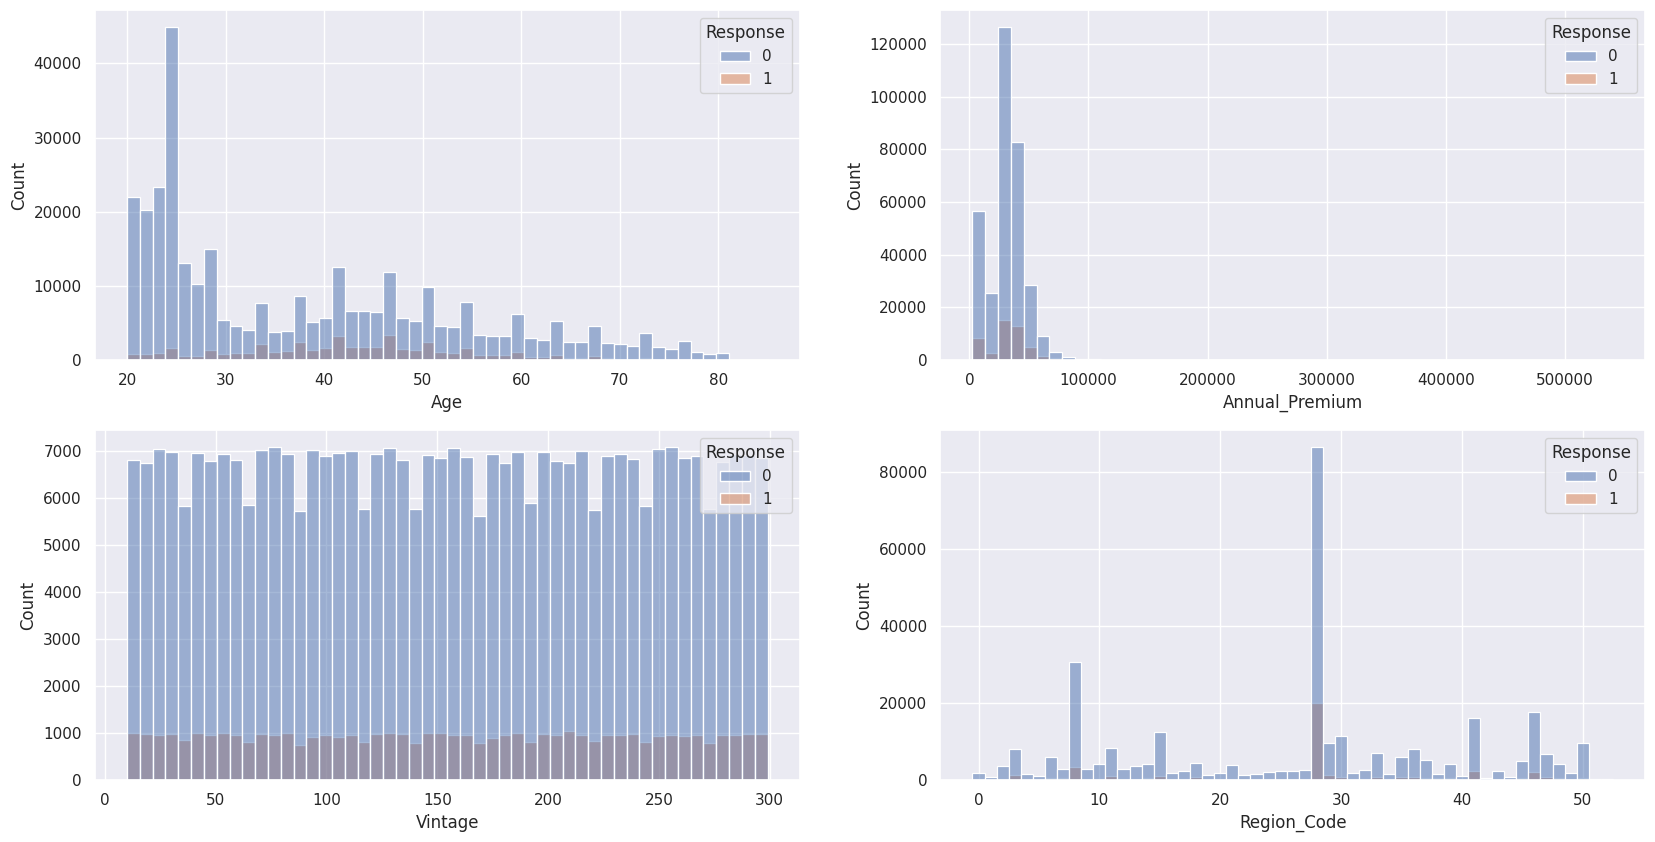

In [186]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
sns.histplot(data=df, x='Age', hue='Response', bins=50, ax=ax[0][0])
sns.histplot(data=df, x='Annual_Premium', bins=50, hue='Response', ax=ax[0][1])
sns.histplot(data=df, x='Vintage', hue='Response', bins=50, ax=ax[1][0])
sns.histplot(data=df, x='Region_Code', hue='Response', bins=50, ax=ax[1][1]);

#### Categorical variables

In [187]:
cat_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_columns

['Gender',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Policy_Sales_Channel']

<Axes: xlabel='Driving_License', ylabel='count'>

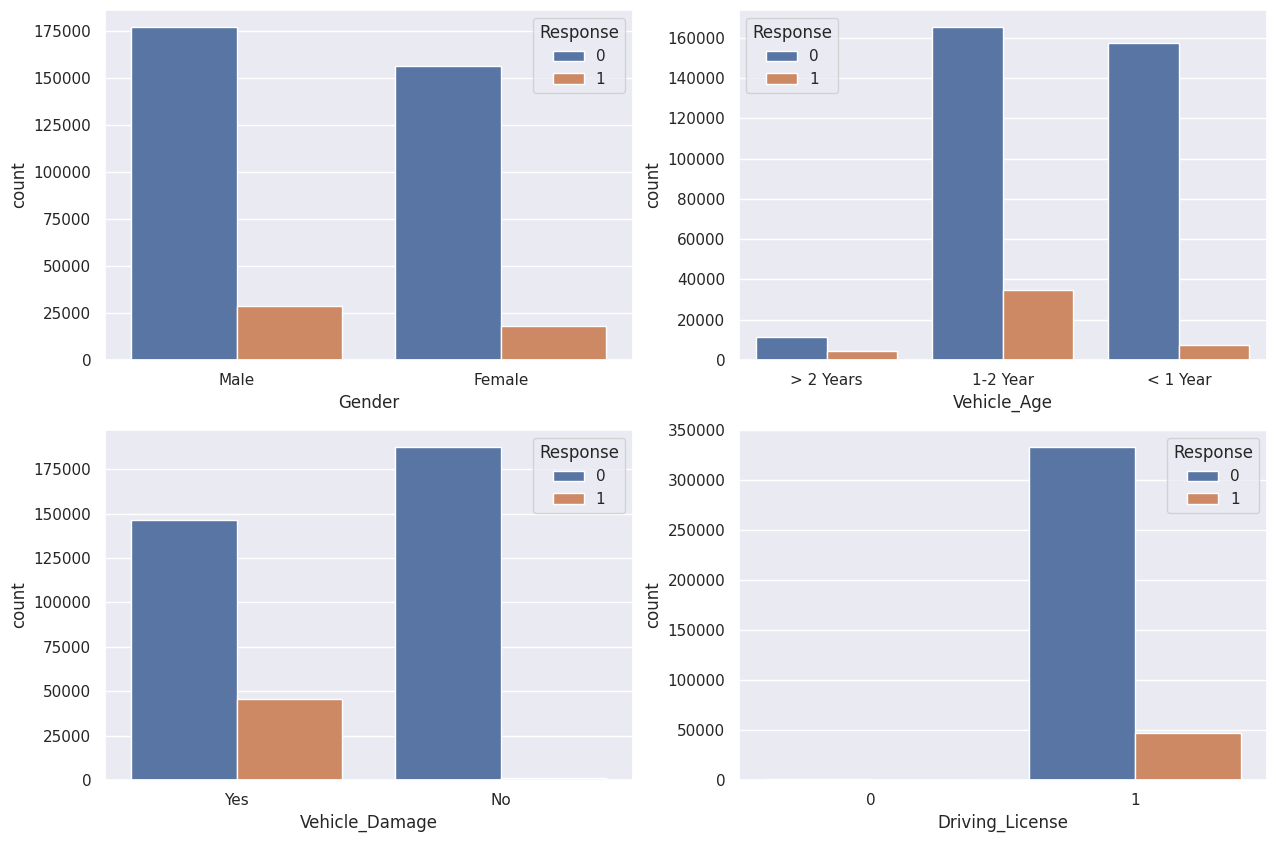

In [188]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.countplot(data=df, x='Gender', hue='Response', ax=ax[0][0])
sns.countplot(data=df, x='Vehicle_Age', hue='Response', ax=ax[0][1])
sns.countplot(data=df, x='Vehicle_Damage', hue='Response', ax=ax[1][0])
sns.countplot(data=df, x='Driving_License', hue='Response', ax=ax[1][1])

## 2.2. Hypothesis

#### **H1**: Individuals between 30 and 50 years old would be more likely to purchase a vehicle insurance.
-> True

In [189]:
between_30_50 = df.query('Age >= 30 & Age <= 50 & Response == 1').shape[0]
below_30 = df.query('Age < 30 and Response == 1').shape[0]
over_50 = df.query('Age > 50 and Response == 1').shape[0]

In [190]:
aux1 = pd.DataFrame({'below_30': [below_30],
                     'between_30_50': [between_30_50],
                     'over_50': [over_50]})
aux1

,below_30,between_30_50,over_50
0,6374,28431,11905


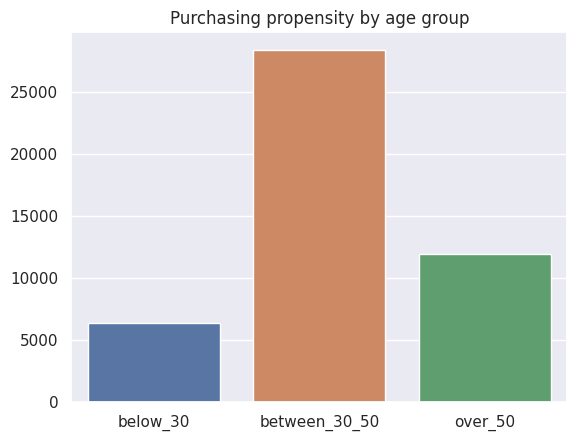

In [191]:
sns.barplot(data=aux1)
plt.title('Purchasing propensity by age group');

#### **H2**: Women would be more interested in having vehicle insurance.
-> False. 10,4% of total women would purchase compared to 13,8% of total men.

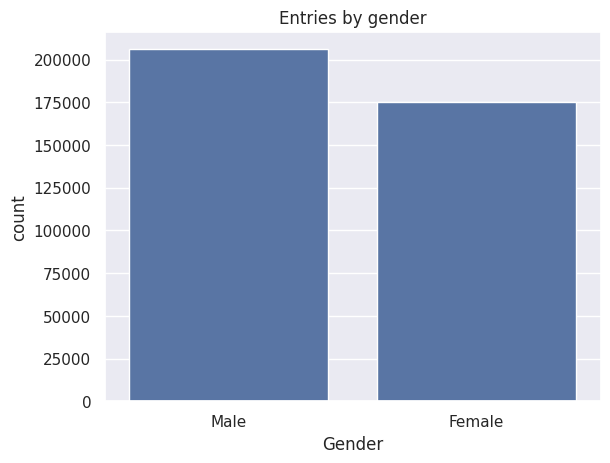

In [192]:
sns.countplot(data=df, x='Gender')
plt.title('Entries by gender');

In [193]:
# Result given in proportion by gender
gender_count = pd.crosstab(df['Response'], df['Gender'], normalize='columns')
gender_count

Gender,Female,Male
Response,,
0,0.896098,0.861589
1,0.103902,0.138411


Text(0.5, 1.0, 'Interest by gender')

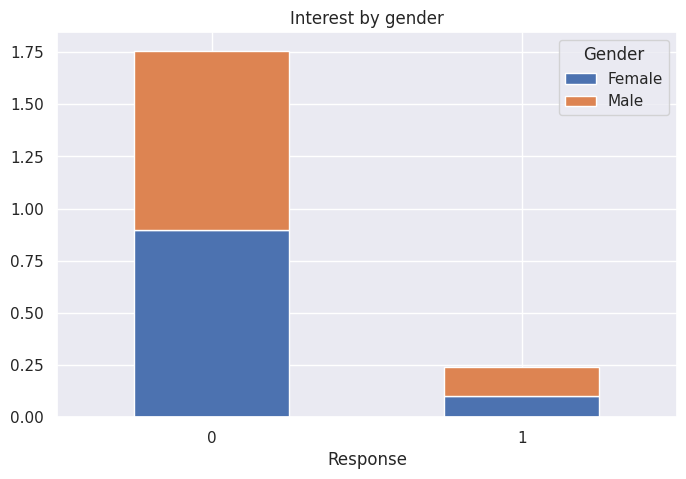

In [194]:
fig, ax = plt.subplots(figsize=(8,5))
gender_count.plot(kind='bar', stacked=True, ax=ax)
plt.xticks(rotation=0)
plt.title('Interest by gender')

#### **H3**: Individuals who already have driver license and got the vehicle damage in the past would be more interested in vehicle insurance.
-> False.

In [195]:
aux3 = df.query('Driving_License == 1 & Vehicle_Damage == "Yes"')['Response'].value_counts()

Text(0.5, 1.0, 'Purchasing propensity among people who Driving_License = 1 and Vehicle_Damage = Yes')

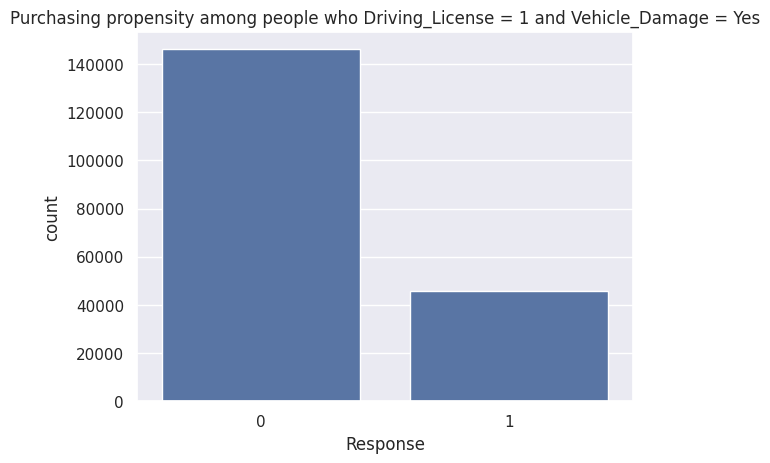

In [196]:
sns.barplot(data=aux3)
plt.title('Purchasing propensity among people who Driving_License = 1 and Vehicle_Damage = Yes')

#### **H4**: Individuals who already have vehicle insurance (previously insured) would not be interested in vehicle insurance.
-> True. 99,91% of those who already have insurance would not purchase another one

In [197]:
pd.crosstab(index=df['Response'], columns=df['Previously_Insured'], normalize='columns')

Previously_Insured,0,1
Response,,
0,0.774546,0.999095
1,0.225454,0.000905


#### **H5**: Individuals who got the vehicle damaged and were not previously insured would be more interested in vehicle insurance.
-> False. Even if not being insured, people who have vehicle damaged would not purschase

<Axes: xlabel='Response', ylabel='count'>

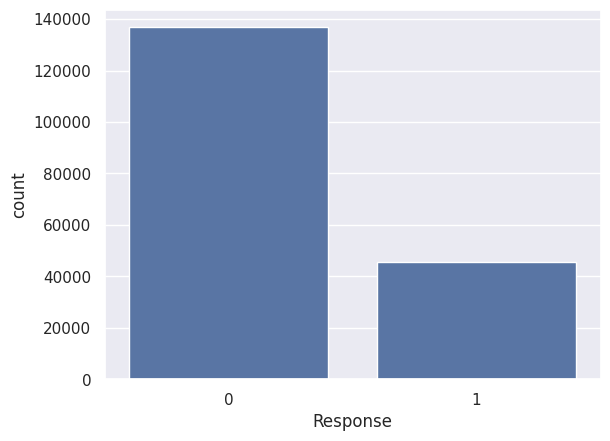

In [198]:
aux5 = df.query('Vehicle_Damage == "Yes" & Previously_Insured == 0')['Response'].value_counts()
sns.barplot(data=aux5)

#### **H6**: Individuals who own vehicle with more than two year would be more interested in vehicle insurance.
-> FALSE. Ownners of vehicles between 1-2 years are the most interested.

In [199]:
aux7 = pd.crosstab(index=df['Response'], columns=df['Vehicle_Age'])
aux7

Vehicle_Age,1-2 Year,< 1 Year,> 2 Years
Response,,,
0,165510,157584,11305
1,34806,7202,4702


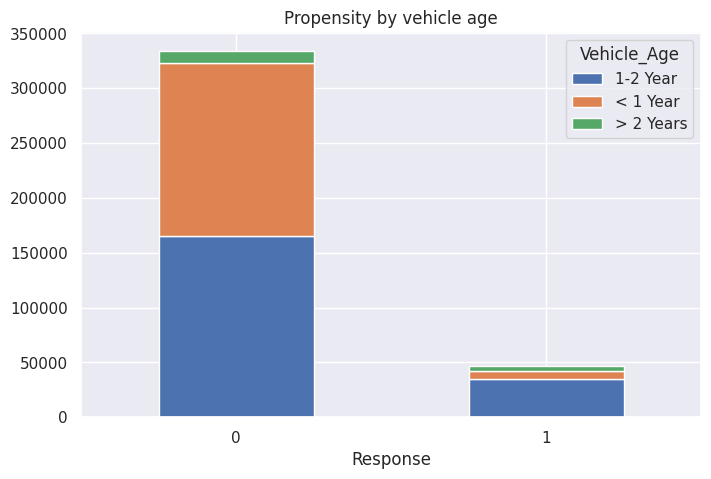

In [200]:
fig, ax = plt.subplots(figsize=(8,5))
aux7.plot(kind='bar', stacked=True, ax=ax)
plt.xticks(rotation=0)
plt.title('Propensity by vehicle age');

<Axes: xlabel='Vehicle_Damage', ylabel='count'>

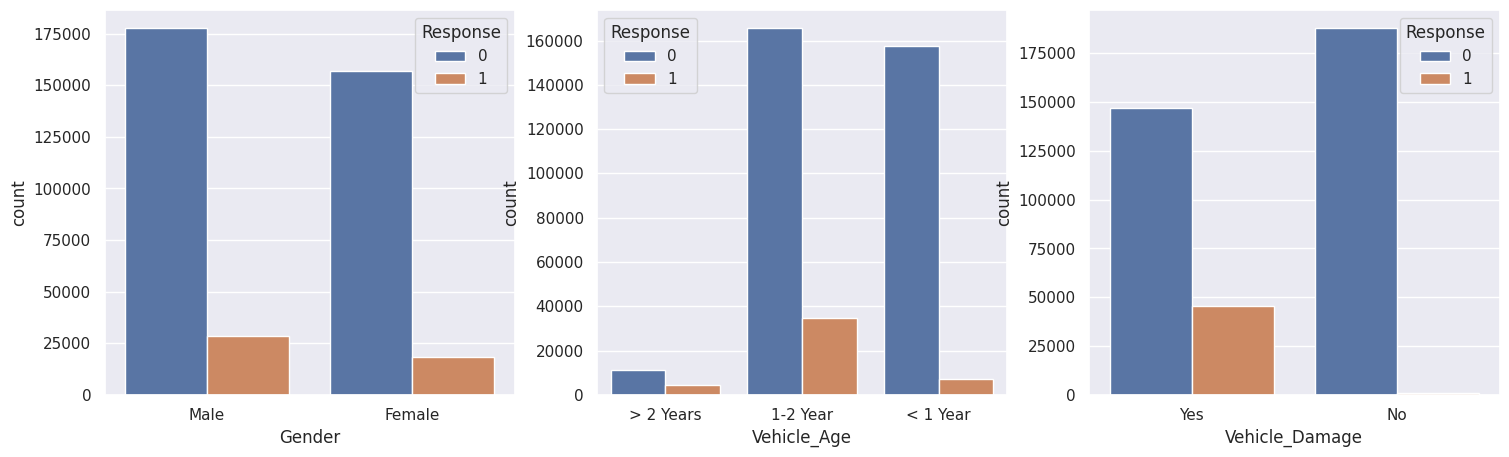

In [201]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
sns.countplot(data=df, x=df['Gender'], hue=df['Response'], ax=ax[0])
sns.countplot(data=df, x=df['Vehicle_Age'], hue=df['Response'], ax=ax[1])
sns.countplot(data=df, x=df['Vehicle_Damage'], hue=df['Response'], ax=ax[2])

#### Vehicle Damage = No --> almost everybody is not interested 

#### Policy sales channel

In [202]:
aux = df.groupby('Policy_Sales_Channel')['Response'].sum().reset_index()
aux

/tmp/ipykernel_226215/1299731882.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux = df.groupby('Policy_Sales_Channel')['Response'].sum().reset_index()


,Policy_Sales_Channel,Response
0,1.0,35
1,2.0,1
2,3.0,159
3,4.0,102
4,6.0,0
...,...,...
150,157.0,1794
151,158.0,135
152,159.0,1
153,160.0,475


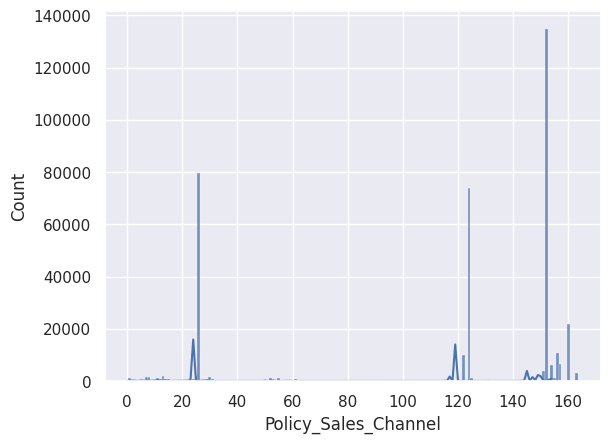

In [203]:
plt.figure()
ax = sns.histplot(data=df, x='Policy_Sales_Channel')
ax = plt.plot(aux['Response'])

# 3. Feature Engineering

## 3.1. Spliting data into train and validation dataframes

In [204]:
df_train, df_valid = train_test_split(df, train_size=0.8, stratify=df['Response'], random_state=seed)

In [205]:
X_train = df_train.drop(columns='Response').copy()
X_valid = df_valid.drop(columns='Response').copy()

y_train = df_train['Response']
y_valid = df_valid['Response']

print(f'Training dataframe shape: {df_train.shape}')
print(f'Validation dataframe shape: {df_valid.shape}')

Training dataframe shape: (304887, 12)
Validation dataframe shape: (76222, 12)


## 3.2. Data preparation

In [206]:
# Make column names lowercase
X_train.columns = X_train.columns.str.lower()
X_valid.columns = X_valid.columns.str.lower()
y_train.name = y_train.name.lower()
y_valid.name = y_valid.name.lower()

In [207]:
# id column has no importance and can be removed
X_train.drop(columns=['id'], inplace=True)
X_valid.drop(columns=['id'], inplace=True)

In [208]:
# Rewrite vehicle age
age_dict = {'1-2 Year': 'between_1_2',
            '< 1 Year': 'below_1',
            '> 2 Years': 'over_2'}

X_train['vehicle_age'] = X_train['vehicle_age'].map(age_dict)
X_valid['vehicle_age'] = X_valid['vehicle_age'].map(age_dict)

In [209]:
num_columns = X_train.select_dtypes(exclude=['object', 'category']).columns.to_list()
cat_columns = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

In [210]:
X_train.nunique()

gender                      2
age                        66
driving_license             2
region_code                53
previously_insured          2
vehicle_age                 3
vehicle_damage              2
annual_premium          46479
policy_sales_channel      154
vintage                   290
dtype: int64

In [211]:
#df_train.dropna(inplace=True)
#df_train.drop_duplicates(inplace=True)

In [212]:
## Transform vehicle_damage to numeric
#df_train['vehicle_damage'] = df_train['vehicle_damage'].apply(lambda x: 0 if x=='No' else 1)

## 3.3. Encoding

### 3.3.1. One hot encode

In [213]:
# General function for One Hot Encoder
def one_hot_encoder(df_to_encode, feature_to_encode):
    encoder = OneHotEncoder(drop='if_binary')
    new_features = encoder.fit_transform(df_to_encode[feature_to_encode]).toarray()
    df_to_encode[encoder.get_feature_names_out()] = new_features
    df_to_encode.drop(columns=encoder.feature_names_in_[0], inplace=True)
    return df_to_encode, encoder

In [214]:
# Gender ---> OBS: Test dummy encoding
X_train, encoding_gender = one_hot_encoder(df_to_encode=X_train, feature_to_encode=['gender'])

In [215]:
# Driving license
X_train, encoding_license = one_hot_encoder(df_to_encode=X_train, feature_to_encode=['driving_license'])

In [216]:
# Previously insured
X_train, encoding_insured = one_hot_encoder(df_to_encode=X_train, feature_to_encode=['previously_insured'])

In [217]:
# Vehicle damage
X_train, encoding_damage = one_hot_encoder(df_to_encode=X_train, feature_to_encode=['vehicle_damage'])

In [218]:
# Vehicle age
X_train, encoding_v_age = one_hot_encoder(df_to_encode=X_train, feature_to_encode=['vehicle_age'])

### 3.3.2. Target encode

In [219]:
# Region code
tar_enc_reg_code = TargetEncoder()
X_train['region_code'] = tar_enc_reg_code.fit_transform(X=X_train[['region_code']], y=y_train)

In [220]:
# Policy sales channel
tar_enc_pol_sales = TargetEncoder()
X_train['policy_sales_channel'] = tar_enc_pol_sales.fit_transform(X=X_train[['policy_sales_channel']], y=y_train)

In [221]:
X_train

,age,region_code,annual_premium,policy_sales_channel,vintage,gender_Male,driving_license_1,previously_insured_1,vehicle_damage_Yes,vehicle_age_below_1,vehicle_age_between_1_2,vehicle_age_over_2
274710,22,0.130014,25455.0,0.028931,203,1.0,1.0,0.0,1.0,1.0,0.0,0.0
216539,26,0.094663,38393.0,0.200304,45,0.0,1.0,1.0,0.0,1.0,0.0,0.0
78983,32,0.187317,32118.0,0.176544,35,0.0,1.0,0.0,1.0,1.0,0.0,0.0
218368,32,0.075830,37711.0,0.028602,215,1.0,1.0,0.0,1.0,1.0,0.0,0.0
307215,24,0.186861,48706.0,0.209334,222,0.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
378816,25,0.084483,23010.0,0.022169,58,1.0,1.0,1.0,1.0,1.0,0.0,0.0
67726,69,0.187529,31630.0,0.200304,290,1.0,1.0,0.0,1.0,0.0,1.0,0.0
91744,24,0.187172,59094.0,0.028865,62,1.0,1.0,0.0,0.0,1.0,0.0,0.0
48700,40,0.094929,28940.0,0.200190,262,0.0,1.0,1.0,0.0,0.0,1.0,0.0


## 3.4. Rescaling

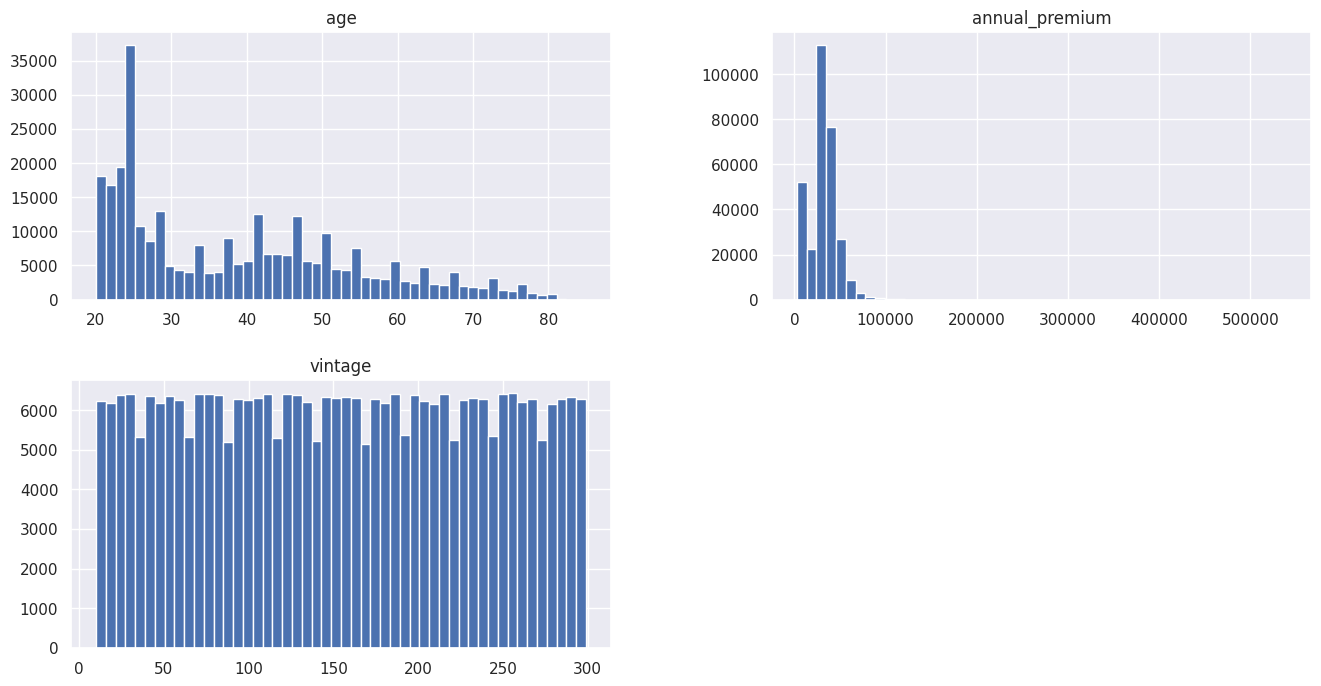

In [222]:
X_train[num_columns].hist(bins=50, figsize=(16,8));

### Vintage - MinMax scaler,Standard scaler, Quantile transform

In [223]:
#std_vintage = MinMaxScaler()
std_vintage = StandardScaler()
#std_vintage = QuantileTransformer()
#std_vintage = PowerTransformer(method='box-cox')
#std_vintage = RobustScaler()

new_vintage = std_vintage.fit_transform(X_train[['vintage']])
X_train['vintage'] = new_vintage

Text(0.5, 1.0, 'Some scalling')

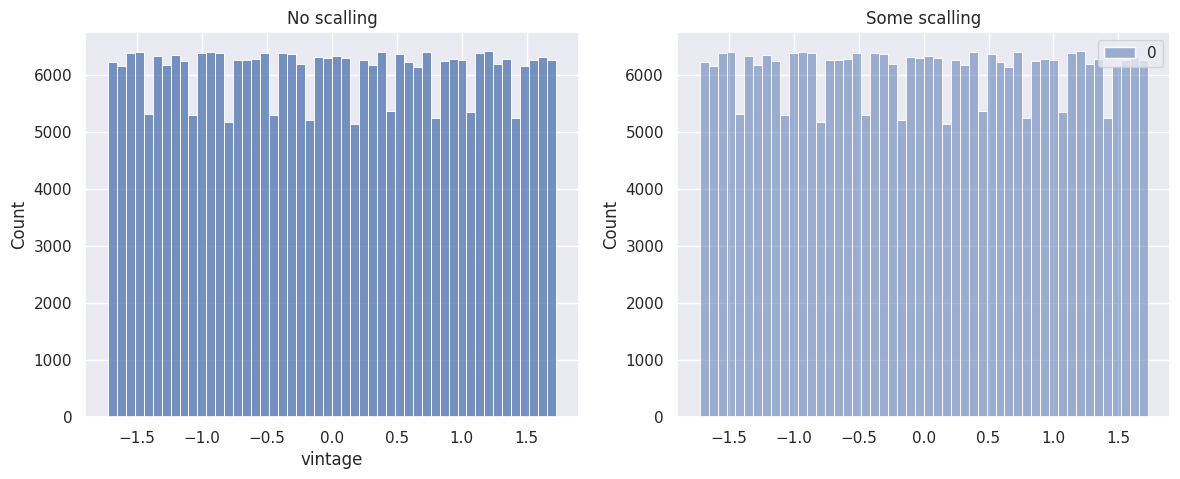

In [224]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.histplot(data=X_train['vintage'], bins=50, ax=ax[0])
sns.histplot(data=new_vintage, bins=50, ax=ax[1])
ax[0].set_title('No scalling')
ax[1].set_title('Some scalling')

### Age - MinMax scaler, Standard scaler, Box-Cox or Quantile transform

In [225]:
#std_age = MinMaxScaler()
std_age = StandardScaler()
#std_age = QuantileTransformer()
#std_age = PowerTransformer(method='box-cox')
#std_age = RobustScaler()

#aux1 = X_train[['age']].transform(np.log1p)
#new_age = std_age.fit_transform(aux1)
new_age = std_age.fit_transform(X_train[['age']])
X_train['age'] = new_age

Text(0.5, 1.0, 'Some scalling')

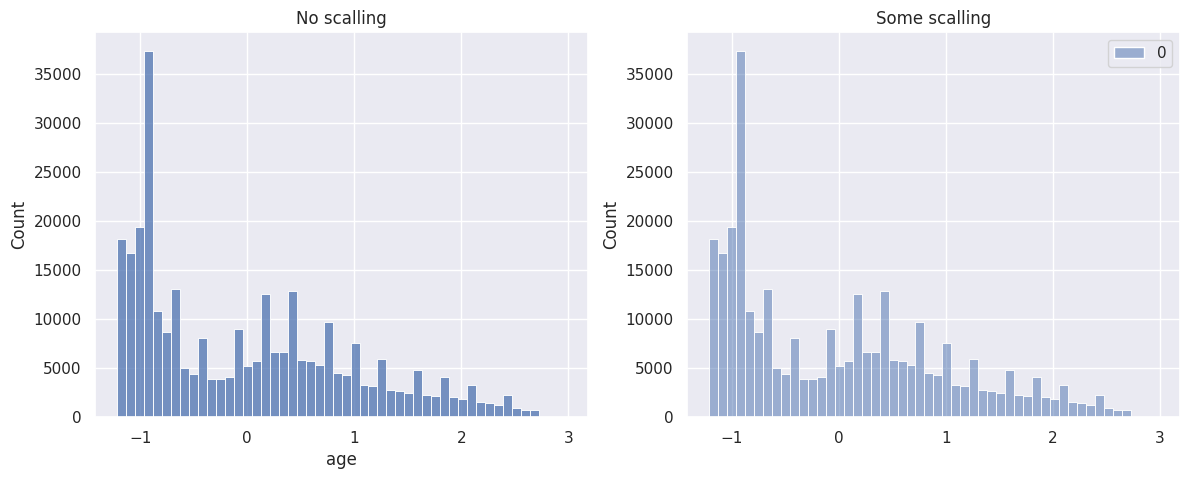

In [226]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.histplot(data=X_train['age'], bins=50, ax=ax[0])
sns.histplot(data=new_age, bins=50, ax=ax[1])
ax[0].set_title('No scalling')
ax[1].set_title('Some scalling')

### Anual premium - Standard scaler, Robust scaler, Box-Cox or Quantile transform

Text(0.5, 1.0, 'Some scalling')

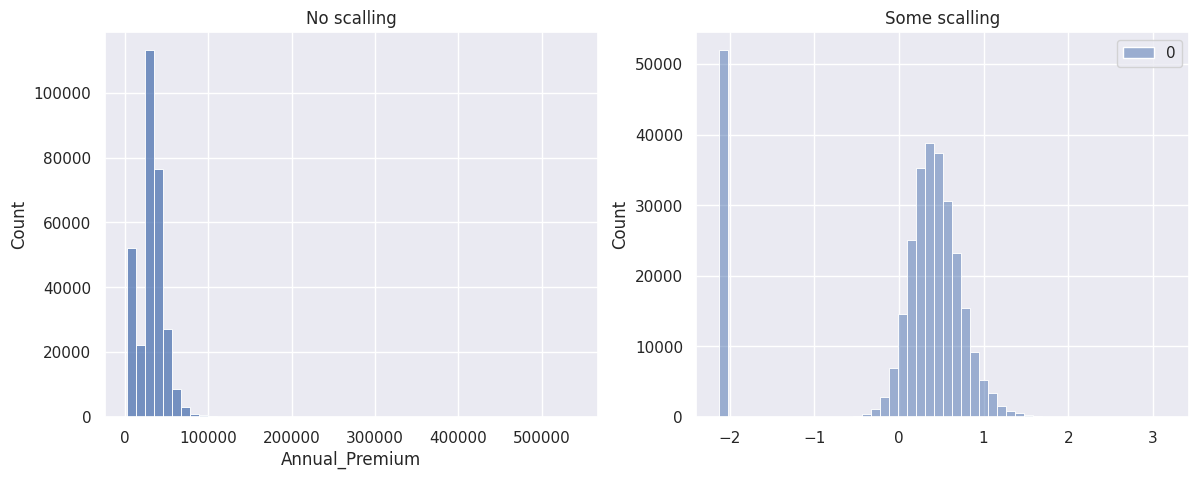

In [227]:
#std_vintage = MinMaxScaler()
std_anual_pr = StandardScaler()
#std_anual_pr = QuantileTransformer()
#std_anual_pr = PowerTransformer(method='box-cox')
#std_anual_pr = RobustScaler()

aux1 = X_train[['annual_premium']].transform(np.log1p)
new_anual_pr = std_anual_pr.fit_transform(aux1)
#new_anual_pr = std_anual_pr.fit_transform(X_train[['annual_premium']])
X_train['annual_premium'] = new_anual_pr

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.histplot(data=df_train['Annual_Premium'], bins=50, ax=ax[0])
sns.histplot(data=new_anual_pr, bins=50, ax=ax[1])
ax[0].set_title('No scalling')
ax[1].set_title('Some scalling')

## 3.5. Validation dataframe

In [228]:
X_valid[encoding_gender.get_feature_names_out()] =encoding_gender.transform(X=X_valid[['gender']]).toarray()
X_valid.drop(columns=encoding_gender.feature_names_in_[0], inplace=True)

X_valid[encoding_license.get_feature_names_out()] =encoding_license.transform(X=X_valid[['driving_license']]).toarray()
X_valid.drop(columns=encoding_license.feature_names_in_[0], inplace=True)

X_valid[encoding_insured.get_feature_names_out()] =encoding_insured.transform(X=X_valid[['previously_insured']]).toarray()
X_valid.drop(columns=encoding_insured.feature_names_in_[0], inplace=True)

X_valid[encoding_damage.get_feature_names_out()] =encoding_damage.transform(X=X_valid[['vehicle_damage']]).toarray()
X_valid.drop(columns=encoding_damage.feature_names_in_[0], inplace=True)

X_valid[encoding_v_age.get_feature_names_out()] =encoding_v_age.transform(X=X_valid[['vehicle_age']]).toarray()
X_valid.drop(columns=encoding_v_age.feature_names_in_[0], inplace=True)

In [229]:
X_valid['region_code'] = tar_enc_reg_code.transform(X=X_valid[['region_code']])

X_valid['policy_sales_channel'] = tar_enc_pol_sales.transform(X=X_valid[['policy_sales_channel']])

In [230]:
X_valid['age'] = std_age.transform(X=X_valid[['age']])

X_valid['vintage'] = std_vintage.transform(X=X_valid[['vintage']])

X_valid['annual_premium'] = std_anual_pr.transform(X=X_valid[['annual_premium']].transform(np.log1p))

In [231]:
X_valid

,age,region_code,annual_premium,policy_sales_channel,vintage,gender_Male,driving_license_1,previously_insured_1,vehicle_damage_Yes,vehicle_age_below_1,vehicle_age_between_1_2,vehicle_age_over_2
16221,0.977946,0.187041,1.206187,0.199687,-1.211808,1.0,1.0,0.0,1.0,0.0,0.0,1.0
342480,-0.826727,0.127950,-0.124149,0.212094,1.501225,0.0,1.0,0.0,1.0,0.0,1.0,0.0
20915,-0.891180,0.187041,1.006338,0.189077,1.202433,1.0,1.0,0.0,1.0,1.0,0.0,0.0
38703,-0.633369,0.138781,-2.128108,0.268610,0.963399,1.0,1.0,0.0,1.0,0.0,1.0,0.0
363808,-0.697822,0.187041,0.828969,0.199687,1.059013,0.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
151614,0.075610,0.187041,0.379264,0.189077,-0.172011,1.0,1.0,0.0,1.0,0.0,1.0,0.0
170170,0.011157,0.103315,-2.128108,0.189077,0.282153,0.0,1.0,0.0,0.0,0.0,1.0,0.0
303221,1.364662,0.187041,0.499743,0.199687,1.560984,1.0,1.0,0.0,1.0,0.0,1.0,0.0
333829,-1.020085,0.073653,0.233081,0.028816,-0.673982,1.0,1.0,1.0,0.0,1.0,0.0,0.0


# 4. Machine Learning Modeling

## 4.1. Model trainning

### 4.1.1. Logistic Regression

In [232]:
log_reg_clf = LogisticRegression()

In [233]:
log_reg_clf.fit(X=X_train, y=y_train)
y_pred_log_reg = log_reg_clf.predict(X=X_valid)
y_pred_proba_log_reg = log_reg_clf.predict_proba(X=X_valid)

### 4.1.2. KNN

In [234]:
knn_clf = KNeighborsClassifier()

In [235]:
knn_clf.fit(X=X_train, y=y_train)
y_pred_knn = knn_clf.predict(X=X_valid)
y_pred_proba_knn = knn_clf.predict_proba(X=X_valid)

### 4.3.2. Random Forest

In [236]:
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=2, random_state=42)

In [237]:
rf_clf.fit(X=X_train, y=y_train)
y_pred_rf = rf_clf.predict(X=X_valid)
y_pred_proba_rf = rf_clf.predict_proba(X=X_valid)

### 4.3.3. HGBoosting

In [238]:
hgb_clf = HistGradientBoostingClassifier(random_state=42)

In [239]:
hgb_clf.fit(X=X_train, y=y_train)
y_pred_hgb = hgb_clf.predict(X=X_valid)
y_pred_proba_hgb = hgb_clf.predict_proba(X=X_valid)

### 4.3.4. Results

In [240]:
def metrics(models):

    results = {'Model': [],
               'Accuracy': [],
               'Precision': [],
               'Recall': []}

    for name, pred in models.items():
        results['Model'].append(name)
        results['Accuracy'].append(accuracy_score(y_pred=pred, y_true=y_valid))
        results['Precision'].append(precision_score(y_pred=pred, y_true=y_valid))
        results['Recall'].append(recall_score(y_pred=pred, y_true=y_valid))

    results = pd.DataFrame(results).set_index('Model')
    results.index.names = [None]
    return pd.DataFrame(results)

In [241]:
models = {'Logistic Regression': y_pred_log_reg,
          'KNN': y_pred_knn,
          'Random Forest': y_pred_rf,
          'HGBoost': y_pred_hgb}

In [242]:
results = metrics(models)
results.style.highlight_max(color='green', axis=0)

,Accuracy,Precision,Recall
Logistic Regression,0.876873,0.377143,0.007065
KNN,0.855895,0.330442,0.171270
Random Forest,0.871126,0.378104,0.079854
HGBoost,0.876702,0.318182,0.005245


<Axes: title={'center': 'HGBoosting'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

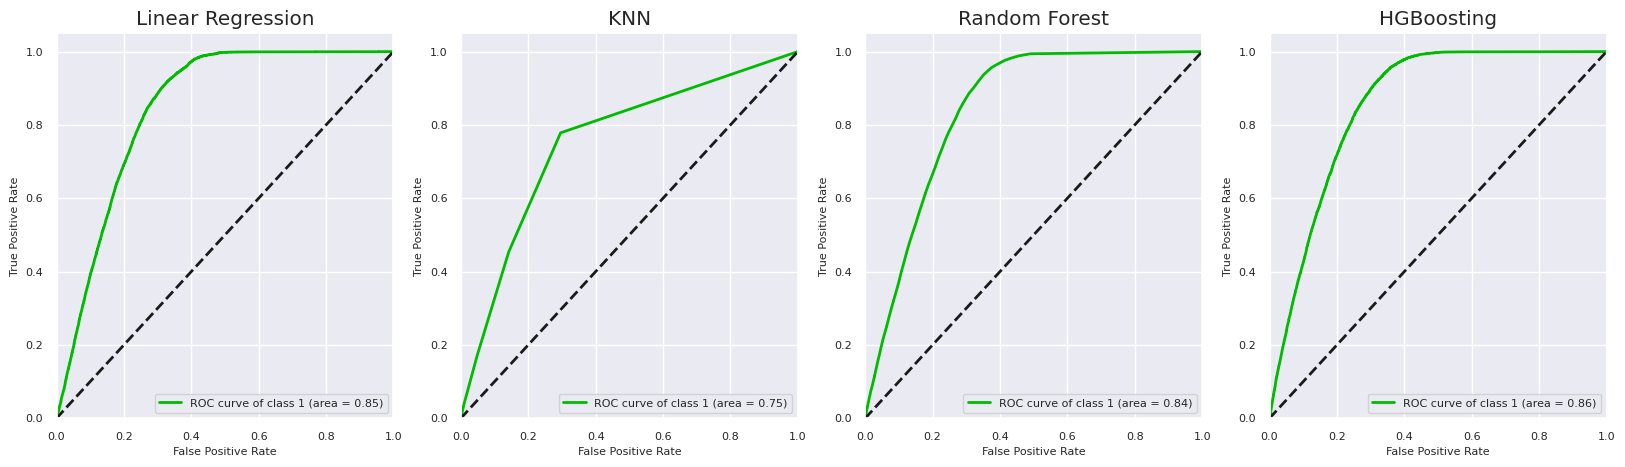

In [243]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 5))
skplt.metrics.plot_roc(y_probas=y_pred_proba_log_reg, y_true=y_valid, plot_macro=False, plot_micro=False,
                       title='Linear Regression', classes_to_plot=1, text_fontsize=8, ax=ax[0])
skplt.metrics.plot_roc(y_probas=y_pred_proba_knn, y_true=y_valid, plot_macro=False, plot_micro=False,
                       title='KNN', classes_to_plot=1, text_fontsize=8, ax=ax[1])
skplt.metrics.plot_roc(y_probas=y_pred_proba_rf, y_true=y_valid, plot_macro=False, plot_micro=False,
                       title='Random Forest', classes_to_plot=1, text_fontsize=8, ax=ax[2])
skplt.metrics.plot_roc(y_probas=y_pred_proba_hgb, y_true=y_valid, plot_macro=False, plot_micro=False,
                       title='HGBoosting', classes_to_plot=1, text_fontsize=8, ax=ax[3])

<Axes: title={'center': 'HGBoosting'}, xlabel='Recall', ylabel='Precision'>

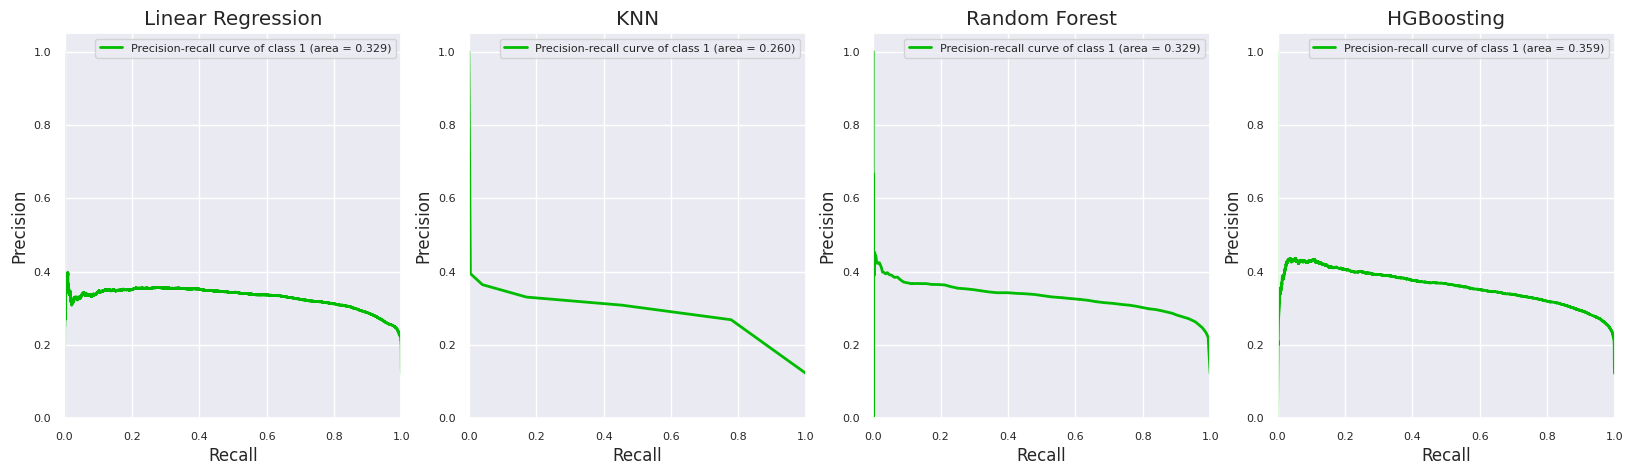

In [244]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 5))
skplt.metrics.plot_precision_recall(y_probas=y_pred_proba_log_reg, y_true=y_valid, title='Linear Regression',
                                    plot_micro=False, classes_to_plot=1, text_fontsize=8, ax=ax[0])
skplt.metrics.plot_precision_recall(y_probas=y_pred_proba_knn, y_true=y_valid, title='KNN',
                                    plot_micro=False, classes_to_plot=1, text_fontsize=8, ax=ax[1])
skplt.metrics.plot_precision_recall(y_probas=y_pred_proba_rf, y_true=y_valid, title='Random Forest',
                                    plot_micro=False, classes_to_plot=1, text_fontsize=8, ax=ax[2])
skplt.metrics.plot_precision_recall(y_probas=y_pred_proba_hgb, y_true=y_valid, title='HGBoosting',
                                    plot_micro=False, classes_to_plot=1, text_fontsize=8, ax=ax[3])

**Strategy**
- Reach the highest number of customers with potencial of purchasing insurance
- Recall must be increased in order to contact as many interested as possible

<Axes: title={'center': 'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

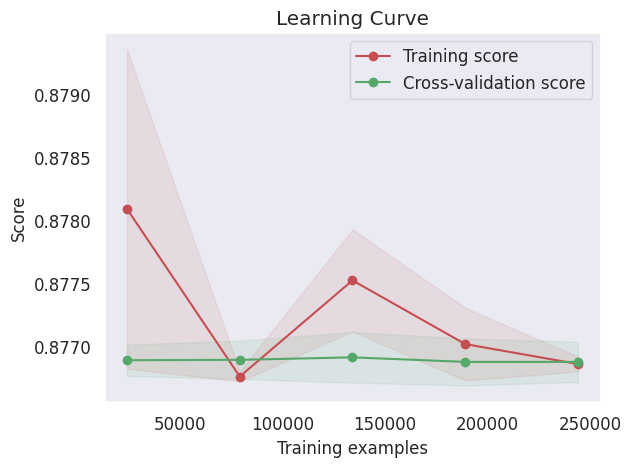

In [245]:
skplt.estimators.plot_learning_curve(clf=log_reg_clf, X=X_train, y=y_train)